# Assignment: Exploratory Data Analysis
### `! git clone https://github.com/ds4e/visualization`
### Do One.

**Q1.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

**Q2.** Go to https://data.cms.gov/search.
1. Pick a dataset about something you are interested in. Download the data and data dictionary. If you really can't decide, you can always use this one: https://data.cms.gov/medicare-current-beneficiary-survey-mcbs/medicare-current-beneficiary-survey-data
3. Does the data dictionary document how missings are handled? For categorical variables, does it describe the possible values and missing value codes? For the numeric variables, does it describe how missing values are handled? Summarize your opinion of the data dictionary.
4. Pick out a few interesting variables, and explain why you find them jointly interesting. Clean those variables, documenting your choices by commenting in the code or in a markdown chunk in a notebook.
5. For the variables you select, make a boxplot for each numeric variable and a bar graph for each categorical variable. Do you see any outliers?
6. Create a histogram or kernel density plot, and explain what you see. Do the results require any transformations to rescale them? 
7. Create a scatter plot, and describe the relationship you see.
8. Create a table (cross tabulation, variance-covariance, or a `.describe()` five-number summary), and explain what you see.

**Q3.** This is a case study about understanding and visualizing risk over time, involving a dataset with information about breast cancer mortality rates over time, conditional on different treatments.

1. Load the `./data/Breast Cancer METABRIC.csv` dataset. It has a bunch of interesting variables, but the mains of interest for this question are `Overall Survival (Months)`, which is  and `Overall Survival Survival Status`, which records whether the patient is Alive or Deceased.
2. Make one kernel density plot of `Overall Survival (Months)`, and a second conditional on `Overall Survival Status`. Interpret these plots. What patterns do you see? 

3. The **hazard rate** gives the instantaneous risk of an event occurring, given that it hasn't already happened. It is defined as
$$
h(t) = \dfrac{f(t)}{1-F(t)}
$$
where $F(t)$ is the distribution of arrival times and $f(t)=F'(t)$ is the density of arrival times. Roughly, conditional on $T \ge t$, what is the probability that $T=t$? The cumulative hazard is given by
$$
H(t) = \int_0^t h(z) dz.
$$
The following function computes the hazard rate and cumulative hazard using something called the Nelson-Ahlen estimator. Run your data through it. Interpret the plots for the hazard rate and cumulative hazard rate. What patterns do you see?

```
def hazard(df):
    """ Compute cumulative hazard rate using Nelson-Ahlen estimator. """
    at_risk = df.shape[0]
    arrivals = df['survival'].sort_values().dropna().tolist()
    hazard_rate = []
    times = []
    for t in arrivals:
        select = (df['survival']==t)*(df['Overall Survival Status']=='Deceased')
        deaths_t = df[select].shape[0]
        if deaths_t > 0:
            hazard_rate.append(deaths_t/at_risk)
            times.append(t)
            at_risk -= deaths_t
    cumulative_hazard = np.cumsum(hazard_rate)
    return cumulative_hazard, times, hazard_rate
```

4. There are lots of additional categorical variables in the METABRIC dataset. Pick a categorical variable, and plot the hazard rate and cumulative hazard for each category. Do you see any interesting patterns? Is one group more likely to survive, or do their hazard rates cross over time?
5. These plots are very helpful for understanding how patients respond to treatment. Discuss how they might be used in practice, to help doctors and patients make decisions about care.

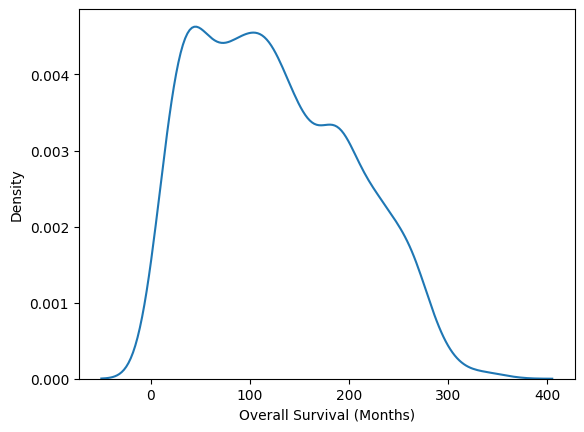

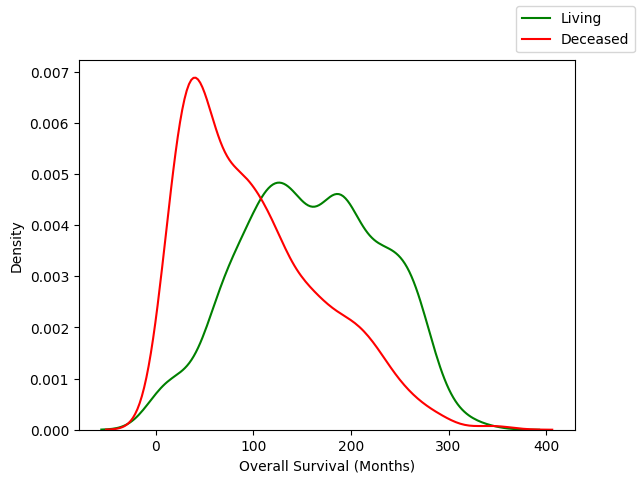

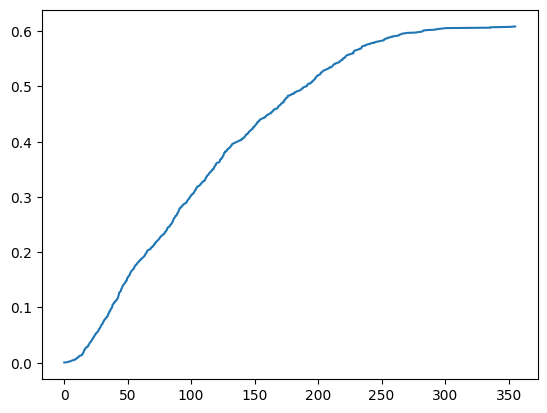

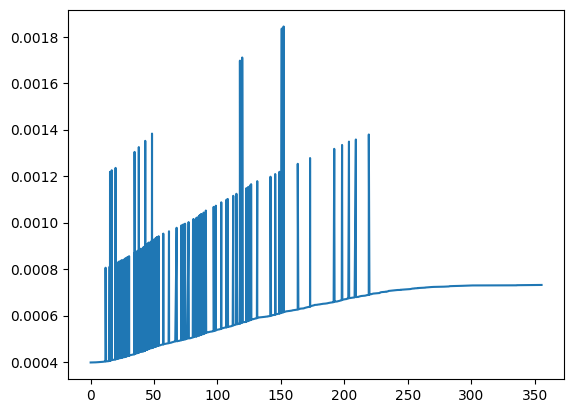

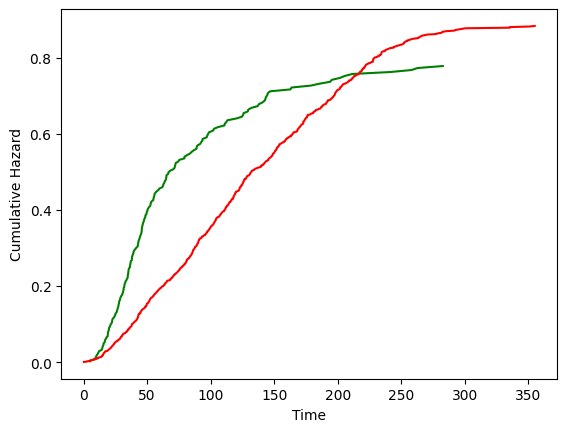

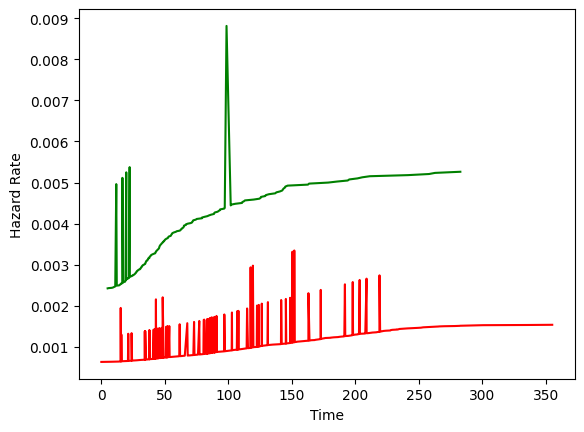

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hazard(df):
    """ Compute cumulative hazard rate using Nelson-Ahlen estimator. """
    at_risk = df.shape[0]
    arrivals = df['Overall Survival (Months)'].sort_values().dropna().tolist()
    hazard_rate = []
    times = []
    for t in arrivals:
        if times and times[-1] == t:
            continue
        select = (df['Overall Survival (Months)']==t)*(df['Overall Survival Status']=='Deceased')
        deaths_t = df[select].shape[0]
        if deaths_t > 0:
            hazard_rate.append(deaths_t/at_risk)
            times.append(t)
            at_risk -= deaths_t
    cumulative_hazard = np.cumsum(hazard_rate)
    return cumulative_hazard, times, hazard_rate

df = pd.read_csv("../data/Breast Cancer METABRIC.csv")

sns.kdeplot(df, x="Overall Survival (Months)")
plt.show()
fig = plt.figure()
sns.kdeplot(df[df["Overall Survival Status"] == "Living"], x="Overall Survival (Months)", color="green")
sns.kdeplot(df[df["Overall Survival Status"] == "Deceased"], x="Overall Survival (Months)", color="red")
fig.legend(labels=["Living", "Deceased"])
plt.show()

cumulative_hazard, times, hazard_rate = hazard(df)
plt.plot(times, cumulative_hazard)
plt.show()
plt.plot(times, hazard_rate)
plt.show()

cumulative_hazard_1, times_1, hazard_rate_1 = hazard(df[df["Chemotherapy"] == "Yes"])
df_chemo = pd.DataFrame({"Time": times_1, "Cumulative Hazard": cumulative_hazard_1, "Hazard Rate": hazard_rate_1})
cumulative_hazard_2, times_2, hazard_rate_2 = hazard(df[df["Chemotherapy"] == "No"])
df_no_chemo = pd.DataFrame({"Time": times_2, "Cumulative Hazard": cumulative_hazard_2, "Hazard Rate": hazard_rate_2})
fig = plt.figure()
sns.lineplot(data=df_chemo, x="Time", y="Cumulative Hazard", color="green")
sns.lineplot(data=df_no_chemo, x="Time", y="Cumulative Hazard", color="red")
plt.show()
fig = plt.figure()
sns.lineplot(data=df_chemo, x="Time", y="Hazard Rate", color="green")
sns.lineplot(data=df_no_chemo, x="Time", y="Hazard Rate", color="red")
plt.show()

2. It seems like most people die in the first year or two -- that's where the peak is for the distribution of just deceased people, with a steady decline after that point. The plots for living and deceased people cross around the 9-year mark, so I suppose that if you make it that far you've got pretty good odds.
3. The cumulative distribution is S-shaped, but the tail at the top is a lot longer than that at the bottom. The normal hazard plot is really weird to me since it seems somewhat S-shaped but has a ton of spikes at irregular intervals. I guess those are just points where a lot of people passed away and it's messing with the distribution.
4. Green is people who underwent chemotherapy; red is people who did not. Chemotherapy has a much higher cumulative hazard rate early on but also plateaus well before the alternative -- basically, it's riskier upfront but if you can make it through you're in a better place than without chemo. People without chemo had their cumulative hazard risk steadily increase for twenty years or so before plateauing.
5. These can be used to determine how risky a certain treatment is over a period of time as part of evaluating whether it's appropriate for a patient or not. The chemotherapy plots are a good example of this. These could also be used to gain an understanding of the outcomes of a specific condition, as seen in the first couple plots.

**Q4.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use a data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform 
$$
k(z) = \begin{cases} 
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is 
$$
k(z) = \begin{cases} 
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.